# Regression Models

## Imports

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from yellowbrick.regressor import PredictionError

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nbimporter

import TrainTestEvalSplit as split
from sklearn.model_selection import KFold

import pickle
from sklearn.utils import check_X_y
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import SelectFromModel

## Import File

In [2]:
full_df = pd.read_csv("../../../Data_thesis/Full_Datasets/Full.csv")
full_df["Date"] = pd.to_datetime(full_df["Date"], format="%Y-%m-%d")

full_df.head()

,Date,Hour,weekday,is_weekend,Sensor,SensorLongitude,SensorLatitude,CrowdednessCount,Lon_4.8971927,Lon_4.8973336,...,Nieuwmarkt score,Nieuwmarkt weight,Nieuwezijds Kolk score,Nieuwezijds Kolk weight,Dam score,Dam weight,Spui score,Spui weight,Centraal Station score,Centraal Station weight
0,2018-03-11,100,6.0,1.0,GAWW-04,4.897908,52.373283,886,0,0,...,0.000000,0.999994,0.000000,0.999987,102.996844,0.999969,0.000000,0.999954,472.993853,0.999987
1,2018-03-11,2100,6.0,1.0,GAWW-07,4.900441,52.374414,1603,0,0,...,346.998829,0.999997,198.995171,0.999976,1266.930956,0.999946,133.989730,0.999923,3859.981463,0.999995
2,2018-03-11,2100,6.0,1.0,GAWW-08,4.897193,52.371650,21,1,0,...,346.997145,0.999992,198.996668,0.999983,1266.966573,0.999974,133.995346,0.999965,3859.909232,0.999976
3,2018-03-11,2100,6.0,1.0,GAWW-09,4.898479,52.375040,88,0,0,...,346.997014,0.999991,198.997601,0.999988,1266.952991,0.999963,133.991938,0.999940,3859.978146,0.999994
4,2018-03-11,2100,6.0,1.0,GAWW-10,4.898808,52.372369,49,0,0,...,346.998943,0.999997,198.995907,0.999979,1266.951383,0.999962,133.993174,0.999949,3859.941786,0.999985


## Train/Test/Eval split

In [3]:
size = 0.8
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [4]:
x_train, y_train, x_test, y_test, x_eval, y_eval, train_dates = split.trainTestSplit(full_df, size)

## Feature Selection

In [18]:
X=x_train.drop(columns={"Date"})
y=y_train["CrowdednessCount"]

feature_model = SelectFromModel(RandomForestRegressor(n_estimators=250, random_state=42))
feature_model.fit(X, y)

selected_feat= X.columns[(feature_model.get_support())]

print(selected_feat)

Index(['weekday', 'LonScaled', 'month_sin', 'month_cos', 'hour_sin',
       'hour_cos', 'Nieuwmarkt weight', 'Dam score', 'Dam weight',
       'Spui weight', 'Centraal Station score', 'Centraal Station weight'],
      dtype='object')


## Models

### Baseline: Linear Regression
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

#### Training

In [7]:
base = LinearRegression()

In [8]:
mean_score = 0
mean_rmse = 0

for train_index, val_index in kf.split(train_dates):
    base.fit(x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"}),
             y_train[y_train["Date"].isin(train_dates[train_index])]["CrowdednessCount"])
    
    mean_score += base.score(x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}),
             y_train[y_train["Date"].isin(train_dates[val_index])]["CrowdednessCount"])
    
    y_pred_base = base.predict(x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}))
    mean_rmse += np.sqrt(mean_squared_error(y_pred_base, 
                                            y_train[y_train["Date"].isin(train_dates[val_index])]["CrowdednessCount"]))

mean_score /= 10
mean_rmse /= 10

print("Average R^2 Score: ", mean_score)
print("Average RMSE Score: ", mean_rmse)

Average R^2 Score:  0.5868043896991378
Average RMSE Score:  632.1788795449481


#### Hyperparameter Testing

In [32]:
base = LinearRegression()

fit_intercept = [True, False]
normalize = [True, False]
copy_X = [True, False]

params = {"fit_intercept": fit_intercept,
         "normalize": normalize,
         "copy_X": copy_X}

scores = ["r2", "neg_mean_squared_error"]

hyp = RandomizedSearchCV(estimator=base, param_distributions=params, n_iter=10, scoring=scores, n_jobs=2, cv=10,
                        random_state=42, refit="r2")

base_model = hyp.fit(x_eval, y_eval)

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [34]:
print("Best estimator: ", base_model.best_estimator_)
print("Best R2 score: ", base_model.best_score_)

Best estimator:  LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=True)
Best R2 score:  0.49621485695006273


#### Test

R^2 Score:  0.598165493894075
RMSE:  652.1669538465576


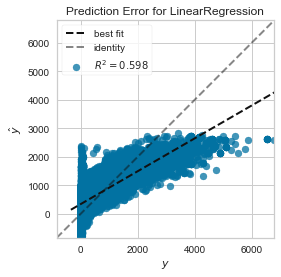

In [9]:
test_base_score = base.score(x_test, y_test)

y_pred_test_base = base.predict(x_test)
test_base_mse = mean_squared_error(y_pred_test_base, y_test)

print("R^2 Score: ", test_base_score)
print("RMSE: ", np.sqrt(test_base_mse))

visualizer = PredictionError(base)
visualizer.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"])  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

### Random Forrest Regressor 
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

#### Training

In [10]:
rfg = RandomForestRegressor()

In [11]:
mean_score = 0
mean_rmse = 0

for train_index, val_index in kf.split(train_dates):
    rfg.fit(x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"}),
             y_train[y_train["Date"].isin(train_dates[train_index])]["CrowdednessCount"])
    
    mean_score += rfg.score(x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}),
             y_train[y_train["Date"].isin(train_dates[val_index])]["CrowdednessCount"])
    
    y_pred_rfg = rfg.predict(x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}))
    mean_rmse += np.sqrt(mean_squared_error(y_pred_rfg, 
                                            y_train[y_train["Date"].isin(train_dates[val_index])]["CrowdednessCount"]))

mean_score /= 10
mean_rmse /= 10

print("Average R^2 Score: ", mean_score)
print("Average RMSE Score: ", mean_rmse)

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Average R^2 Score:  0.8716367079228992
Average RMSE Score:  348.9476422562867


#### Hyperparameter Tuning

In [40]:
rfg = RandomForestRegressor()

n_estimators = [350, 400, 450]
criterion = ["mse"]
max_features = ["log2", "auto", None]
bootstrap = [True]
oob_score = [True, False]

params = {"n_estimators": n_estimators,
         "criterion": criterion,
         "max_features": max_features,
         "bootstrap": bootstrap,
         "oob_score": oob_score}

scores = ["r2", "neg_mean_squared_error"]

hyp = RandomizedSearchCV(estimator=rfg, param_distributions=params, n_iter=10, scoring=scores, n_jobs=2, cv=10,
                        random_state=42, refit="r2")

best_model = hyp.fit(x_eval, y_eval)

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [42]:
print("Best estimator: ", best_model.best_estimator_)
print("Best R2 score: ", best_model.best_score_)

Best estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
           oob_score=True, random_state=None, verbose=0, warm_start=False)
Best R2 score:  0.7983605617552826


#### Test

R^2 Score:  0.8968760606571681
RMSE:  330.3808927446635


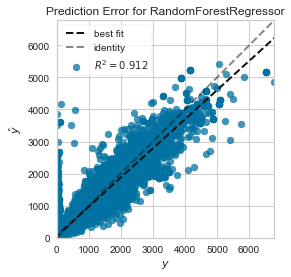

In [12]:
test_rfg_score = rfg.score(x_test, y_test)

y_pred_test_rfg = rfg.predict(x_test)
test_rfg_mse = mean_squared_error(y_pred_test_rfg, y_test)

print("R^2 Score: ", test_rfg_score)
print("RMSE: ", np.sqrt(test_rfg_mse))

visualizer = PredictionError(rfg)
visualizer.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"])  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

#### Save Model

In [16]:
filename = "../../../Data_thesis/Models/rfg_model.sav"

pickle.dump(rfg, open(filename, 'wb'))

### XGBoost Regressor
Through [SciKit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html) 

#### Training

In [13]:
xgbr = xgb.XGBRegressor()

In [14]:
mean_score = 0
mean_rmse = 0

for train_index, val_index in kf.split(train_dates):
    
    x_train_con, y_train_con = check_X_y(X=x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"}),
                                        y=y_train[y_train["Date"].isin(train_dates[train_index])]["CrowdednessCount"])
    
    xgbr.fit(x_train_con,y_train_con)
    
    x_val_con, y_val_con = check_X_y(X=x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}),
                                        y=y_train[y_train["Date"].isin(train_dates[val_index])]["CrowdednessCount"])
    
    mean_score += xgbr.score(x_val_con,y_val_con)
    
    y_pred_xgbr = xgbr.predict(x_val_con)
    mean_rmse += np.sqrt(mean_squared_error(y_pred_xgbr,y_val_con))

mean_score /= 10
mean_rmse /= 10

print("Average R^2 Score: ", mean_score)
print("Average RMSE Score: ", mean_rmse)

Average R^2 Score:  0.8145228205093777
Average RMSE Score:  422.308075756786


#### Hyperparameter Tuning

In [ ]:
xgbr = xgb.XGBRegressor()

learning_rate = [0.05, 0.1, 0.25, 0.5]
n_estimators = [100, 150, 200, 300, 500]
booster = ["gbtree"]
objective = ["reg:linear", "reg:logistic", "reg:gamma", "reg:tweedie"]

params = {"learning_rate": learning_rate,
         "n_estimators": n_estimators,
         "booster": booster,
         "objective": objective}

scores = ["r2", "neg_mean_squared_error"]

hyp = RandomizedSearchCV(estimator=xgbr, param_distributions=params, n_iter=10, scoring=scores, n_jobs=2, cv=10,
                        random_state=42, refit="r2")

xgbr_model = hyp.fit(x_eval, y_eval)

In [ ]:
print("Best estimator: ", xgbr_model.best_estimator_)
print("Best R2 score: ", xgbr_model.best_score_)

#### Test

R^2 Score:  0.8351491082944498
RMSE:  417.7157256246082


D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


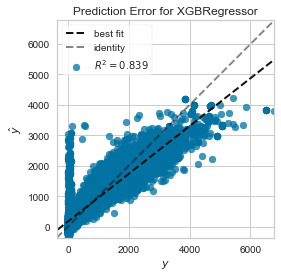

In [15]:
x_test_con, y_test_con = check_X_y(X=x_test, y=y_test)

test_xgbr_score = xgbr.score(x_test_con, y_test_con)

y_pred_test_xgbr = xgbr.predict(x_test_con)
test_xgbr_mse = mean_squared_error(y_pred_test_xgbr, y_test_con)

print("R^2 Score: ", test_xgbr_score)
print("RMSE: ", np.sqrt(test_xgbr_mse))

visualizer = PredictionError(xgbr)
visualizer.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"]) # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

#### Save model to File

In [18]:
filename = "../../../Data_thesis/Models/xgbr_model.sav"

pickle.dump(xgbr, open(filename, 'wb'))